# Computing planar potential flows with package `ViscousFlow`

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using Compat
using Compat: range
using LinearAlgebra

### First, some generalities

#### First create a grid and a Laplacian operator on it

In [4]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [5]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 128, ny = 128) grid with spacing 1.0

#### Now create a circular shape, with discrete points and associated regularization and interpolation operator

In [6]:
n = 196;
θ = range(0,stop=2π,length=n+1);
R = 0.5;
xb = 1.0 .+ R*cos.(θ)
yb = 1.0 .+ R*sin.(θ)
ds = (2π/n)*R;
X = VectorData(xb[1:n],yb[1:n]);
f = ScalarData(X);

In [7]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.009797638653862


In [8]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [9]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


#### Create some data structures for general use

In [10]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w);

### Solve flow generated by a translating cylinder

  0.004359 seconds (91 allocations: 1.153 MiB)


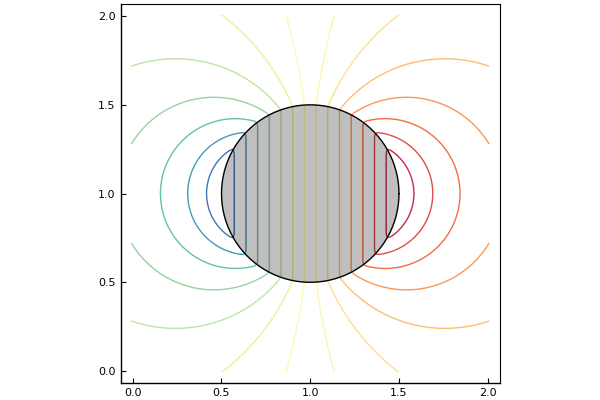

In [39]:
ψb .= -(xb[1:n] .- 1);
@time ψ,f = PS\(w,ψb)

#### Plot the result

In [ ]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

Compare the generated vortex sheet `f/ds` with the exact solution

In [42]:
fex = -2*cos.(θ[1:n]);
errinf = LinearAlgebra.norm(f./ds-fex,Inf)

0.04160331209142765

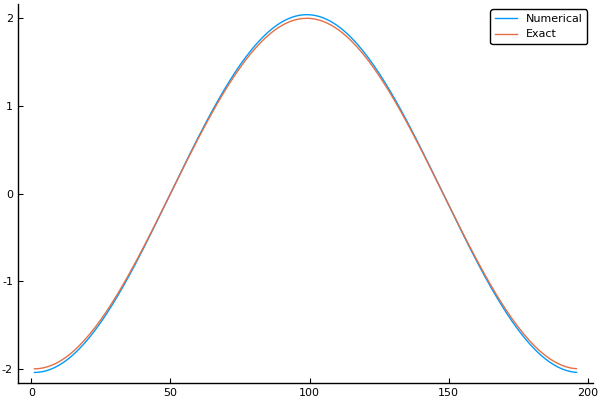

In [43]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

#### Now try storing the Schur matrix

In [44]:
L⁻¹(w::T) where {T} = L\w
PSstore = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,store=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


This way is significantly faster

  0.002513 seconds (41 allocations: 651.547 KiB)


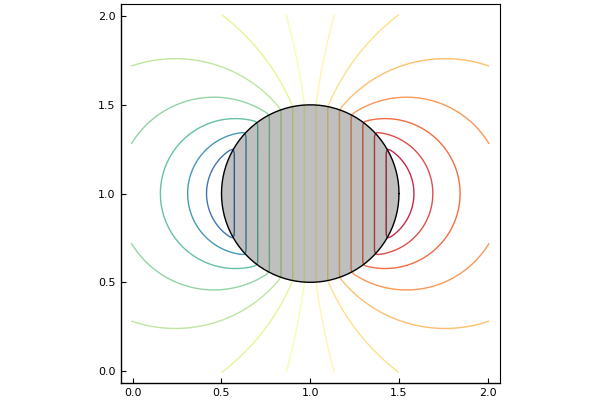

In [45]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
f .= ones(Float64,n)*ds;
ψ = Nodes(Dual,w);
@time ψ,f = PSstore\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

But there is significantly more noise in the force

In [46]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f./ds-fex,Inf)

0.22855215027259246

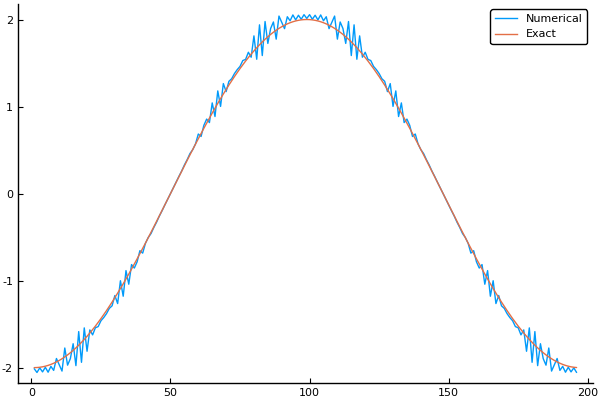

In [47]:
plot(f./ds,label="Numerical")
plot!(fex,label="Exact")

So let's filter it

In [48]:
Ẽ = Regularize(X,dx;weights=ds,filter=true)
H̃mat = RegularizationMatrix(Ẽ,f,w);
Ẽmat = InterpolationMatrix(Ẽ,w,f);

In [49]:
f̃ = ScalarData(X);

In [50]:
P(f) = Ẽmat*(H̃mat*f)
PScond = SaddleSystem((w,f̃),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true,conditioner=P,store=true)

Saddle system with 196 constraints and
   State of type Nodes{Dual,128,128}
   Force of type ScalarData{196}


  0.002951 seconds (46 allocations: 779.672 KiB)


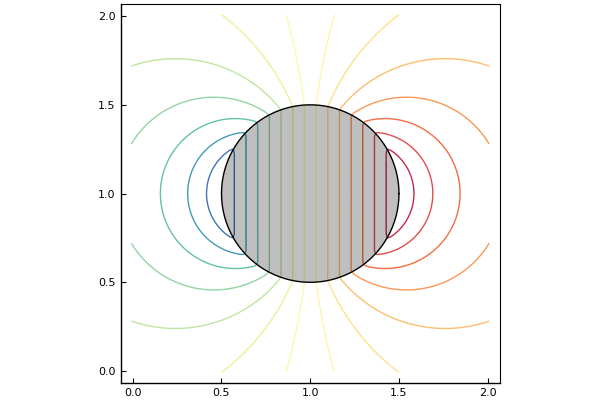

In [51]:
ψb = ScalarData(X);
w = Nodes(Dual,(nx,ny));
ψb .= -(xb[1:n] .- 1);
ψ = Nodes(Dual,w);
@time ψ,f̃ = PScond\(w,ψb)
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)
plot!(xb,yb,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black)

In [52]:
fex = -2*cos.(θ[1:n]);
errinf = norm(f̃./ds-fex,Inf)

0.052911768219712885

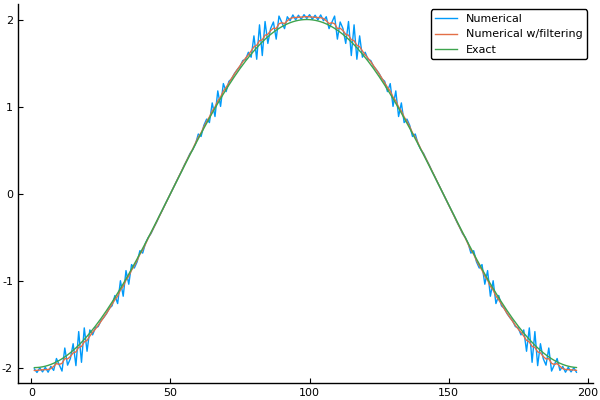

In [53]:
plot(f./ds,label="Numerical")
plot!(f̃./ds,label="Numerical w/filtering")
plot!(fex,label="Exact")

### Now flow about a cylinder with net circulation

#### Set up some helpful operators

In [29]:
oB = zeros(size(f))
oB .= 1;

In [23]:
S = Matrix(PS.S);

In [56]:
S₀ = transpose(oB)*(S\oB)
T = S - oB*transpose(oB)/S₀;

#### Now set the problem parameters

In [71]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 1;

#### The vortex sheet strength

In [87]:
# Note that the first term is actually zero when `ψb` is uniform:
f .= S\(T*(S\ψb) .+ Γ0*oB/S₀);

#### Check that this `f` gives correct circulation

In [73]:
sum(f)

0.9999999999999996

#### Now the streamfunction

In [75]:
ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\ψb))

1.5507044895456807

In [77]:
ψ .= -(L\(Hmat*f)) .+ ψ₀;

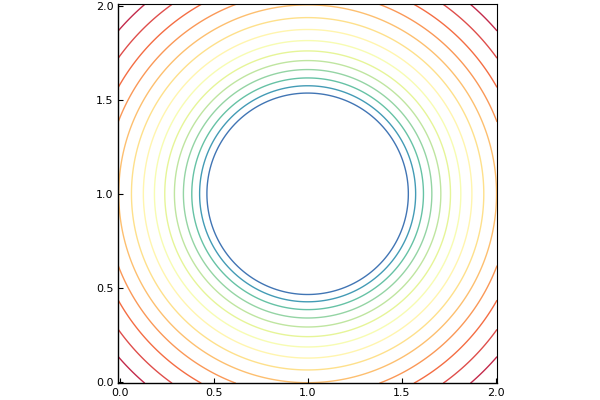

In [79]:
xg,yg = coordinates(ψ,dx=dx)
plot(xg,yg,ψ)

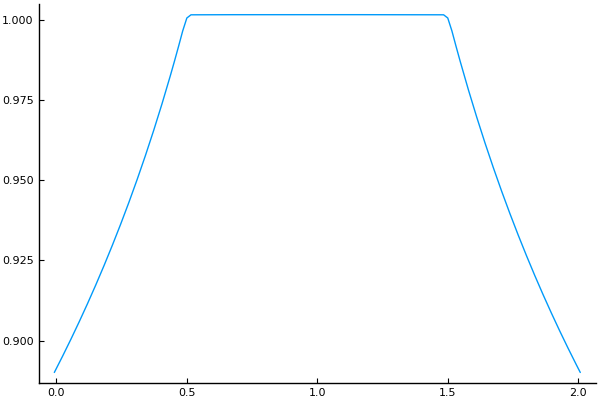

In [82]:
jcent = ny ÷ 2
plot(xg,ψ[:,jcent],legend=:false)

In [84]:
function laplacian_symm!(out::Nodes{Dual,NX, NY}, w::Nodes{Dual,NX, NY}) where {NX, NY}
    @inbounds for y in 2:NY-1, x in 2:NX-1
        out[x,y] = w[x,y-1] + w[x-1,y] - 4w[x,y] + w[x+1,y] + w[x,y+1]
    end
    @inbounds for y in 2:NY-1
        out[1,y]  = w[1,y-1]            - 4w[1,y] + w[2,y] + w[1,y+1]
        out[NX,y] = w[NX,y-1] + w[NX-1,y]- 4w[NX,y]        + w[NX,y+1]
    end
    @inbounds for x in 2:NX-1
        out[x,1]  = w[x-1,1] + w[x+1,1] - 4w[x,1] + w[x,2]
        out[x,NY] = w[x-1,NY]+ w[x+1,NY]- 4w[x,NY] + w[x,NY-1]
    end
    out[1,1] = -4w[1,1] + w[1,2] + w[2,1]
    out[NX,1] = -4w[NX,1] + w[NX-1,1] + w[NX,2]
    out[1,NY] = -4w[1,NY] + w[1,NY-1] + w[2,NY]
    out[NX,NY] = -4w[NX,NY] + w[NX,NY-1] + w[NX-1,NY]
    out
end

laplacian_symm! (generic function with 1 method)